In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# !pip uninstall umap --yes
# !pip uninstall umap-learn --yes
# !pip3 install umap-learn
# !conda uninstall umap-learn
# !pip freeze
# !conda install -y -c conda-forge umap-learn --force-reinstall

In [3]:
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113 --force-reinstall

In [4]:
# import torchvision

In [5]:
# !pip install decord==0.6.0 h5py==3.5.0 hdfdict==0.3.1 imageio==2.9.0 imageio-ffmpeg==0.4.5 jupyter notebook kymatio==0.2.1 librosa==0.9.1 matplotlib==3.5.1 numba==0.54.1 numpy==1.20.3 opencv-contrib-python==4.5.5.64 opt_einsum==3.3.0 pandas==1.3.5 Pillow==9.0.1 PuLP==2.6.0 PyWavelets==1.2.0  PyYAML==5.4.1 rolling-quantiles==1.0.0 scanimage-tiff-reader==1.4.1 scikit-image==0.19.1 scikit-learn==1.0.2 scipy==1.7.3 seaborn==0.11.2 sparse==0.13.0 tqdm==4.63.0 umap-learn==0.5.3
# !pip3 install torch torchvision==0.12 torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [6]:
# !conda install -y -c conda-forge umap-learn

In [7]:
!pip install numpy==1.21

In [8]:
### Import personal libraries

import importlib.util
import glob
from pathlib import Path
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy.stats
from kymatio import Scattering2D
import json
import numpy as np
print(np.__version__)
import torchvision
print(torchvision.__version__)
import torch
from tqdm.notebook import tqdm, trange
import sklearn
from sklearn.model_selection import train_test_split, ShuffleSplit
import sys

%load_ext autoreload
%autoreload 2
%matplotlib notebook

# sys.path.append(params['paths']['dir_github'])
# sys.path.append('/Users/josh/Documents/github_repos')
sys.path.append('/n/data1/hms/neurobio/sabatini/josh/github_repos')
from basic_neural_processing_modules import torch_helpers, math_functions, classification, h5_handling, plotting_helpers, indexing, misc, decomposition, path_helpers
from GCaMP_ROI_classifier import util, models, training, augmentation, dataset

1.21.0
0.12.0+cu113


In [9]:
debug_mode = False
# debug_mode = True

In [10]:
if debug_mode:
    plot_title_params_key = 'temperature'
    classifier_n_splits = 2
    pc_sweep = [0, 10]
else:
    plot_title_params_key = 'temperature'
    classifier_n_splits = 15
    pc_sweep = [0, 10, 18, 33, 60]

In [11]:
######
# Final Goal: python eval_func.py .../analysis/ROI_net_training/simCLR_paramsweep_temp .../analysis/ROI_net_training/blablahblah_outputs/jobNum_0
######

# base_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/20220510_testingSimCLRscript/jobNum_*/'
# base_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp'
# base_dir = '/Users/josh/Documents/analysis/analysis/ROI_net_training/simCLR_paramsweep_temp'
# base_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp'

input_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp'
output_job_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp_eval/job_0'

jns = sorted(glob.glob(str(Path(input_dir) / 'jobNum_*')))

if debug_mode:
    jns = jns[:2]

In [12]:
# image_out_size = list(dataset[0][0][0].shape)

def model_from_params(params, ModelTackOn, image_out_size=[3, 224, 224], pref_log_all_steps=False):
    base_model_frozen = torchvision.models.__dict__[params['torchvision_model']](pretrained=True)
    for param in base_model_frozen.parameters():
        param.requires_grad = False
    if pref_log_all_steps:
        write_to_log(path_log=path_saveLog, text=f'time:{time.ctime()}  imported pretrained model')

    ### Make combined model

    ## Tacking on the latent layers needs to be done in a few steps.

    ## 0. Chop the base model
    ## 1. Tack on a pooling layer to reduce the size of the convlutional parameters
    ## 2. Determine the size of the output (internally done in ModelTackOn)
    ## 3. Tack on a linear layer of the correct size  (internally done in ModelTackOn)

    if pref_log_all_steps:
        write_to_log(path_log=path_saveLog, text=f'time:{time.ctime()}  making combined model...')

    model_chopped = torch.nn.Sequential(list(base_model_frozen.children())[0][:params['n_block_toInclude']])  ## 0.
    model_chopped_pooled = torch.nn.Sequential(model_chopped, torch.nn.AdaptiveAvgPool2d(output_size=1), torch.nn.Flatten())  ## 1.
    
    data_dim = tuple([1] + list(image_out_size))
    
    model = ModelTackOn(
    #     model_chopped.to('cpu'),
        model_chopped_pooled.to('cpu'),
        base_model_frozen.to('cpu'),
        data_dim=data_dim,
        pre_head_fc_sizes=params['pre_head_fc_sizes'], 
        post_head_fc_sizes=params['post_head_fc_sizes'], 
        classifier_fc_sizes=None,
        nonlinearity=params['head_nonlinearity'],
        kwargs_nonlinearity={},
    )
    return base_model_frozen, model_chopped, model_chopped_pooled, image_out_size, data_dim, model

def helper_make_dataset(X, scripted_transforms_classifier):
    out = dataset.dataset_simCLR(
        X=torch.as_tensor(X, device='cpu', dtype=torch.float32),
        y=torch.as_tensor(torch.zeros(X.shape[0]), device='cpu', dtype=torch.float32),
        n_transforms=1,
        class_weights=np.array([1]),
        transform=scripted_transforms_classifier,
        DEVICE='cpu',
        dtype_X=torch.float32,
    )
    return out

def helper_make_dataloader(ds):
    out = torch.utils.data.DataLoader( 
        ds,
#         batch_size=128,
        batch_size=8,
        shuffle=False,
        drop_last=False
    )
    return out

def get_balanced_sample_weights(labels):
    labels = np.int64(labels.copy())
    counts, vals = np.histogram(labels, bins=np.concatenate((np.unique(labels), [labels.max()+1])))
    vals = vals[:-1]

    n_labels = len(labels)
    weights = n_labels / counts
    
    sample_weights = np.array([weights[l] for l in labels])
    
    return sample_weights

def get_latents_swt(sfs, swt, device_model):
    sfs = torch.as_tensor(np.ascontiguousarray(sfs[None,...]), device=device_model, dtype=torch.float32)
    latents_swt = swt(sfs[None,...]).squeeze()
    latents_swt = latents_swt.reshape(latents_swt.shape[0], -1)
    return latents_swt


In [13]:
pth_fn_dct = {}
log_fn_dct = {}
loss_fn_dct = {}
params_fn_dct = {}
run_outputs_fn_dct = {}
sbatch_config_fn_dct = {}
base_py_fn_dct = {}

params_dct = {}
run_outputs_dct = {}

for jn in jns:
    print(jn)
    
    pth_fn = glob.glob(str(Path(jn) / '*.pth'))
    log_fn = glob.glob(str(Path(jn) / 'log.txt'))
    loss_fn = glob.glob(str(Path(jn) / 'loss.npy'))
    params_fn = glob.glob(str(Path(jn) / 'params.json'))
    run_outputs_fn = glob.glob(str(Path(jn) / 'run_outputs.json'))
    sbatch_config_fn = glob.glob(str(Path(jn) / 'sbatch_config.sh'))
    base_py_fn = glob.glob(str(Path(jn) / '*.py'))
    
    assert len(pth_fn) == 1
    assert len(log_fn) == 1
    assert len(loss_fn) == 1
    assert len(params_fn) == 1
    assert len(run_outputs_fn) == 1
    assert len(sbatch_config_fn) == 1
    assert len(base_py_fn) == 1
    
    
    with open(params_fn[0], 'rb') as f:
        params_dct[jn] = json.load(f)
        
    with open(run_outputs_fn[0], 'rb') as f:
        run_outputs_dct[jn] = json.load(f)
    
    pth_fn_dct[jn] = pth_fn[0]
    log_fn_dct[jn] = log_fn[0]
    loss_fn_dct[jn] = loss_fn[0]
    params_fn_dct[jn] = params_fn[0]
    run_outputs_fn_dct[jn] = run_outputs_fn[0]
    sbatch_config_fn_dct[jn] = sbatch_config_fn[0]
    base_py_fn_dct[jn] = base_py_fn[0]
    
    

/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp/jobNum_0
/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp/jobNum_1


In [14]:
# params = params_lst[0]
# run_outputs = run_outputs_lst[0]

In [15]:
torchvision

<module 'torchvision' from '/home/joz608/.conda/envs/jupyter_launcher/lib/python3.8/site-packages/torchvision/__init__.py'>

In [16]:
# import PIL

In [17]:
# images_labeled.shape, [np.load(path).shape for path in path_labels]

<IPython.core.display.Javascript object>


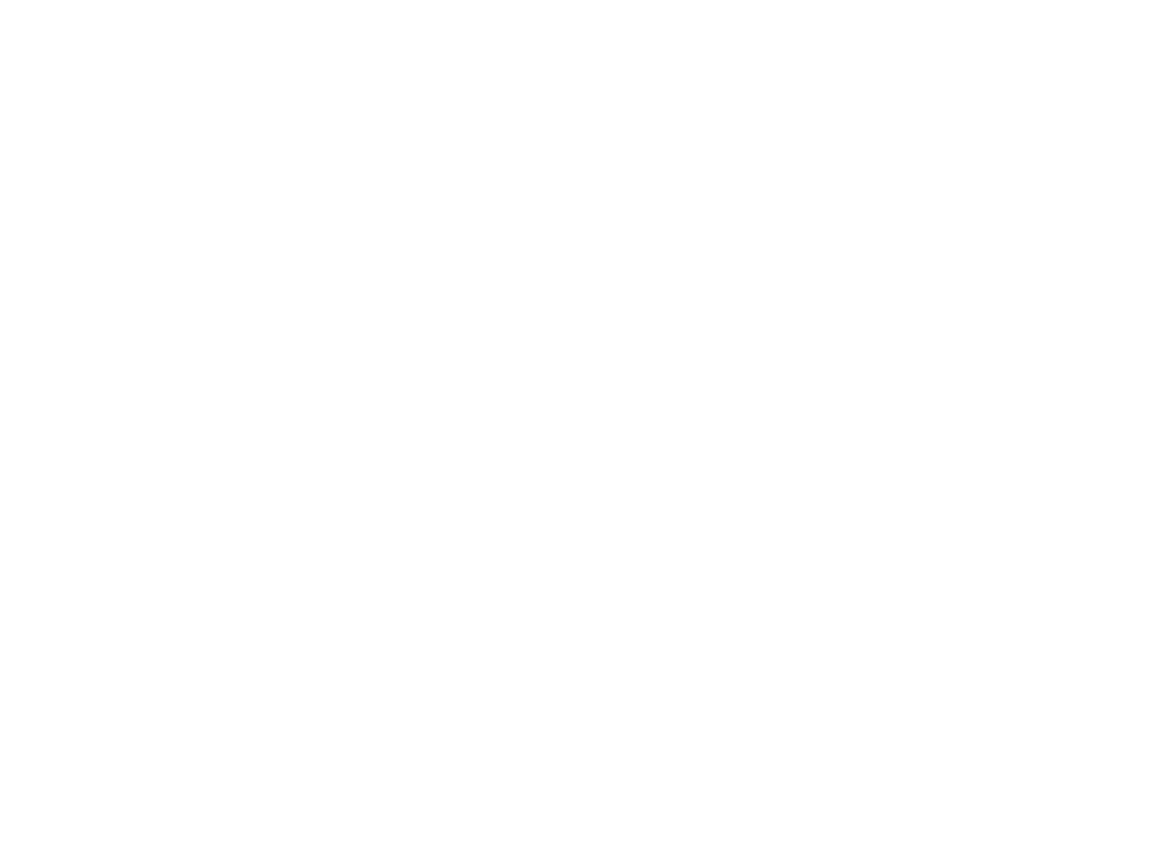

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
path_stat = r'/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/stat.npy'
path_labels = [r'/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/labels_round2_sesh1.npy',
               r'/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/labels_round2_sesh2.npy']

#np.concatenate(
images_labeled = \
    util.import_multiple_stat_files(   
        paths_statFiles=[path_stat],
        out_height_width=[36,36],
        max_footprint_width=241,
        plot_pref=True
    )
# )


sf_all_cat = np.concatenate(images_labeled, axis=0)
sf_all_cat = np.concatenate((sf_all_cat, sf_all_cat), axis=0)

sf_ptiles = np.array([np.percentile(np.sum(sf>0, axis=(1,2)), 90) for sf in tqdm(images_labeled)])
scales_forRS = (250/sf_ptiles)**0.6
sf_rs = [np.stack([util.resize_affine(img, scale=scales_forRS[ii], clamp_range=True) for img in sf], axis=0) for ii, sf in enumerate(tqdm(images_labeled))]
images_labeled = np.concatenate(sf_rs, axis=0)
images_labeled = np.concatenate((images_labeled, images_labeled), axis=0)


labels = classification.squeeze_integers(np.concatenate([np.load(path) for path in path_labels]))

assert images_labeled.shape[0] == labels.shape[0] , 'num images in stat files does not correspond to num labels'


idx_toKeep = np.where(np.logical_not(labels == 4))[0]

images_labeled_clean = images_labeled[idx_toKeep]
labels_clean = labels[idx_toKeep]




<IPython.core.display.Javascript object>


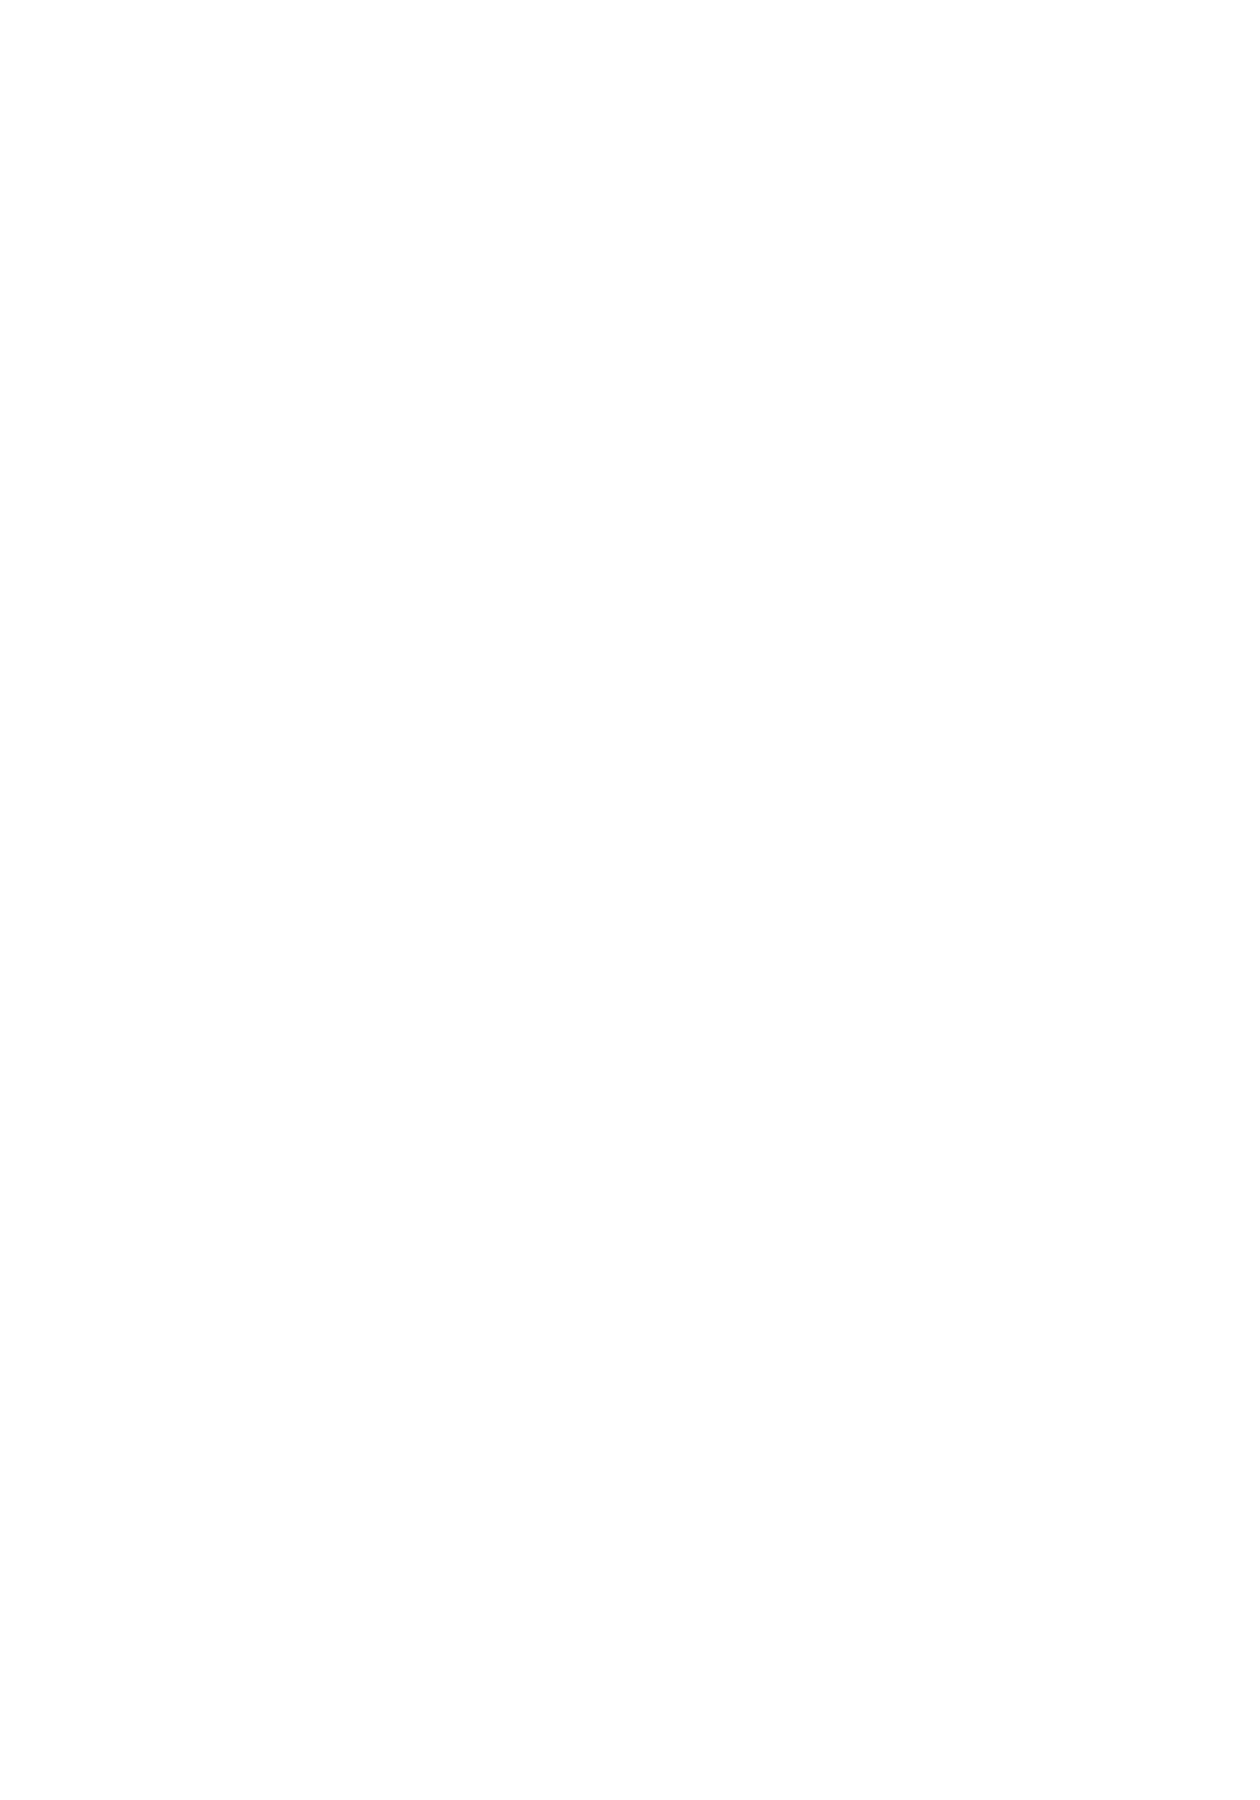

Text(0.5, 1.0, 'ROI sizes resized')

In [19]:
import scipy.signal

figs, axs = plt.subplots(2,1, figsize=(7,10))
axs[0].plot(np.sum(images_labeled > 0, axis=(1,2)))
axs[0].plot(scipy.signal.savgol_filter(np.sum(images_labeled > 0, axis=(1,2)), 501, 3))
axs[0].set_xlabel('ROI number');
axs[0].set_ylabel('mean npix');
axs[0].set_title('ROI sizes raw')

axs[1].plot(np.sum(sf_all_cat > 0, axis=(1,2)))
axs[1].plot(scipy.signal.savgol_filter(np.sum(sf_all_cat > 0, axis=(1,2)), 501, 3))
axs[1].set_xlabel('ROI number');
axs[1].set_ylabel('mean npix');
axs[1].set_title('ROI sizes resized')



In [20]:
mod_dct_dct = {}


# features_nn_plt_dct = {}
# zs_features_nn_plt_dct = {}
# scree_plt_dct = {}

# corr_plt_dct = {}

# C_toUse_plt_dct = {}
# acc_tr_plt_dct = {}
# acc_val_plt_dct = {}

# cm_tr_plt_dct = {}
# cm_val_plt_dct = {}
# cm_relabel_plt_dct = {}

# img_grid_plt_dct = {}
# embeddings_plt_dct = {}
# scores_nn_plt_dct = {}
# title_val_plt_dct = {}

# labels_clean_plt_dct = {}


# scree_dct = {}



scree_plt_dct = {}
corr_plt_dct = {}
acc_plt_dct = {}
cm_plt_dct = {}
embeddings_plt_dct = {}
title_val_plt_dct = {}
features_nn_plt_dct = {}
img_grid_plt_dct = {}
scores_nn_plt_dct = {}
labels_clean_plt_dct = {}
run_id_dct = {}
pc_id_dct = {}


i = -1


prv_params = {}

# for i in trange(len(params_lst)):
for jn in tqdm(params_dct):
    i += 1
    
    
    scree_plt_dct[jn] = {}
    corr_plt_dct[jn] = {}
    acc_plt_dct[jn] = {}
    cm_plt_dct[jn] = {}
    embeddings_plt_dct[jn] = {}
    title_val_plt_dct[jn] = {}
    features_nn_plt_dct[jn] = {}
    img_grid_plt_dct[jn] = {}
    scores_nn_plt_dct[jn] = {}
    labels_clean_plt_dct[jn] = {}
    
    run_id_dct[jn] = str(params_dct[jn][plot_title_params_key])
#     run_id_dct[jn] = {}
#     pc_id_dct[jn] = {}
    
    
    params = params_dct[jn]
    run_outputs = run_outputs_dct[jn]
    base_py_fn = base_py_fn_dct[jn]
    
    if jn == list(params_dct.keys())[0]:
        prv_params = params
    else:
        for key in prv_params:
            if prv_params[key] != params[key]:
                print(params[key], '<>', prv_params[key])
    
    print(base_py_fn)
    
#     print('params', params)
    
    device_dataloader = torch_helpers.set_device(use_GPU=params['useGPU_dataloader'])
    DEVICE = torch_helpers.set_device(use_GPU=params['useGPU_training'])
    
    
    spec = importlib.util.spec_from_file_location(base_py_fn.split('/')[-1][:-3], base_py_fn)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    
    (base_model_frozen, model_chopped, model_chopped_pooled,
    image_out_size, data_dim, model) = model_from_params(params,
                                                         module.ModelTackOn,
                                                         image_out_size=run_outputs['image_resized_shape'],
                                                         pref_log_all_steps=False)
    
    
    
    
    mod_dct_dct[jn] = {name: param.detach().numpy() for name, param in model.named_parameters()}

    
    
    
    ### unfreeze particular blocks in model

    mnp = [name for name, param in model.named_parameters()]  ## 'model named parameters'
    mnp_blockNums = [name[name.find('.'):name.find('.')+8] for name in mnp]  ## pulls out the numbers just after the model name
    mnp_nums = [path_helpers.get_nums_from_string(name) for name in mnp_blockNums]  ## converts them to numbers
#     block_to_freeze_nums = path_helpers.get_nums_from_string(params['block_to_unfreeze'])  ## converts the input parameter specifying the block to freeze into a number for comparison

    m_baseName = mnp[0][:mnp[0].find('.')]

#     for ii, (name, param) in enumerate(model.named_parameters()):
#         if m_baseName in name:
#     #         print(name)
#             if mnp_nums[ii] < block_to_freeze_nums:
#                 param.requires_grad = False
#             elif mnp_nums[ii] >= block_to_freeze_nums:
#                 param.requires_grad = True

#     names_layers_requiresGrad = [( param.requires_grad , name ) for name,param in list(model.named_parameters())]



    # ### Training

    # model.to(device_train)
    # model.prep_contrast()
    model.forward = model.forward_latent
    
    # ### Define augmentation pipeline

    # aug_params = {
    #     'Scale_image_sum': params['augmentation']['Scale_image_sum'],
    #     'ScaleDynamicRange': params['augmentation']['ScaleDynamicRange'],
    #     'TileChannels': params['augmentation']['TileChannels'],
    # }
    # transforms_classifier = torch.nn.Sequential(
    # #     *[augmentation.__dict__[key](**params) for key,params in params['augmentation'].items()]
    #     *[augmentation.__dict__[key](**params) for key,params in aug_params.items()]
    # )

    transforms_classifier = torch.nn.Sequential(
        augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
        torchvision.transforms.Resize(
            size=(224, 224),   
            interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
        augmentation.TileChannels(dim=0, n_channels=3),
    )

    scripted_transforms_classifier = torch.jit.script(transforms_classifier)
    
    
    
    dataset_labeled_clean = helper_make_dataset(images_labeled_clean, scripted_transforms_classifier)
    dataloader_labeled_clean = helper_make_dataloader(dataset_labeled_clean)

    model.eval()
    model.to(DEVICE)
    features_nn = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in tqdm(dataloader_labeled_clean)], dim=0)
    
    if i != 0:
        print(np.allclose(features_nn.numpy(), prv_features_nn))
    prv_features_nn = features_nn.numpy().copy()

    
    
#     device_model = torch_helpers.set_device(use_GPU=True)

#     scattering = Scattering2D(J=2, L=8, shape=images_labeled_clean[0].shape[-2:])
#     if device_model != 'cpu':
#         scattering = scattering.cuda()

#     latents_swt = get_latents_swt(images_labeled_clean, scattering.to(device_model), device_model).cpu()

    torch.corrcoef(features_nn.T).shape

    features_nn_z = scipy.stats.zscore(features_nn.numpy(), axis=0)
    features_nn_z = features_nn_z[:, ~np.isnan(features_nn_z[0,:])]
    features_nn_z = torch.as_tensor(features_nn_z, dtype=torch.float32)

    features_nn_z.shape
    
    for rank in pc_sweep:
        
        if rank == 0:
            comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn_z, zscore=False)
#             comp_nn, scores_nn, SVs, EVR_nn = None, features_nn_z, None, 1.0
            comp, scores_image, SVs, EVR_image = images_labeled_clean.reshape(images_labeled_clean.shape[0], -1), None, None, None
        else:
            comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn_z, rank=rank, zscore=False)
#             comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn_z, rank=40, zscore=True)
        #     comp, scores_swt, SVs, EVR_swt = decomposition.torch_pca(latents_swt, rank=20)
            comp, scores_image, SVs, EVR_image = decomposition.torch_pca(images_labeled_clean.reshape(images_labeled_clean.shape[0], -1), rank=5)

        
#         comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn_z, rank=40, zscore=True)
#     #     comp, scores_swt, SVs, EVR_swt = decomposition.torch_pca(latents_swt, rank=20)
#         comp, scores_image, SVs, EVR_image = decomposition.torch_pca(images_labeled_clean.reshape(images_labeled_clean.shape[0], -1), rank=5)

#         features_nn.shape

    #     features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn, scores_swt]], dim=1)
        
#         if rank == 0:
#             prv_rnk_snn = scores_nn
#         elif rank != 0:
#             print('Same scores_nn?:', np.all(scores_nn == prv_rnk_snn))
        
        features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn]], dim=1)

        features_train, features_val, labels_train, labels_val = sklearn.model_selection.train_test_split(features_norm, labels_clean, test_size=0.3)
        print(f'train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: {features_train.shape, features_val.shape, labels_train.shape, labels_val.shape}')

        acc_train, acc_val = [], []
        C_toUse = np.array([1000, 100, 10,1,0.1,0.01,0.001])
        # C_toUse = np.array([10**-4, 10**-5, 10**-6, 10**-7])
        # C_toUse = np.array([10**2, 10**3, 10**4, 10**5])
        for C in C_toUse:
            logreg = sklearn.linear_model.LogisticRegression(
                solver='lbfgs',
        #         solve='sag'
        #         solve='saga'
        #         solver='newton-cg',
        #         solver='liblinear',
                max_iter=6000, 
                C=C,
                fit_intercept=True, 
                class_weight='balanced',
            #     n_jobs=-1
            )
            logreg.fit(features_train, labels_train)

            acc = logreg.score(features_train, labels_train, sample_weight=get_balanced_sample_weights(labels_train))
            acc_train.append(acc)

            acc = logreg.score(features_val, labels_val, sample_weight=get_balanced_sample_weights(labels_val))
            acc_val.append(acc)
        
        print('acc_train', acc_train)
        print('acc_val', acc_val)


    #     logreg = sklearn.linear_model.LogisticRegression(
    #             solver='lbfgs',
    #     #         solver='sag',
    #     #         solver='saga',
    #     #         solver='newton-cg',
    #     #         solver='liblinear',
    #         max_iter=8000, 
    #         C=10**(0),
    #         fit_intercept=True, 
    #         class_weight='balanced',
    #     #     n_jobs=-1
    #     ).fit(features_train, labels_train)

    #     svm = sklearn.svm.SVC(
    #         C=10**(1), 
    #         kernel='rbf',
    #         degree=3, 
    #         gamma='scale',
    #         coef0=0.0, 
    #         shrinking=True,
    #         probability=False, 
    #         tol=0.001, 
    #         cache_size=200,
    #         class_weight='balanced',
    #         verbose=False, 
    #         max_iter=- 1, 
    #         decision_function_shape='ovr',
    #         break_ties=False,
    #         random_state=None
    #     )
    #     svm.fit(features_train, labels_train)

    #     proba = logreg.predict_proba(features_train)
    #     preds = np.argmax(proba, axis=1)
    #     # preds = svm.predict(features_train_norm).astype(np.int32)
    #     cm_tr = classification.confusion_matrix(preds, labels_train.astype(np.int32))

    #     proba = logreg.predict_proba(features_val)
    #     preds = np.argmax(proba, axis=1)
    #     cm_val = classification.confusion_matrix(preds, labels_val.astype(np.int32))



        splitter = ShuffleSplit(n_splits=classifier_n_splits)
        all_split_inx = list(splitter.split(features_train))

        train_X = [features_norm[_[0]] for _ in all_split_inx]
        test_X = [features_norm[_[1]] for _ in all_split_inx]
        train_y = [labels_clean[_[0]] for _ in all_split_inx]
        test_y = [labels_clean[_[1]] for _ in all_split_inx]
        for ic, c in tqdm(enumerate(C_toUse)):
            train_cms = []
            test_cms = []
            for inx_split in trange(len(train_X)):
                tmp_train_X = train_X[inx_split]
                tmp_train_y = train_y[inx_split]

                tmp_test_X = test_X[inx_split]
                tmp_test_y = test_y[inx_split]


                logreg = sklearn.linear_model.LogisticRegression(
                    solver='lbfgs',
                    max_iter=8000, 
                    C=10**(0),
                    fit_intercept=True, 
                    class_weight='balanced',
                )
                logreg.fit(tmp_train_X, tmp_train_y)

                svm = sklearn.svm.SVC(
                    C=10**(1), 
                    kernel='rbf',
                    degree=3, 
                    gamma='scale',
                    coef0=0.0, 
                    shrinking=True,
                    probability=False, 
                    tol=0.001, 
                    cache_size=200,
                    class_weight='balanced',
                    verbose=False, 
                    max_iter=- 1, 
                    decision_function_shape='ovr',
                    break_ties=False,
                    random_state=None
                )
                svm.fit(tmp_train_X, tmp_train_y)


                proba = logreg.predict_proba(tmp_train_X)
                preds = np.argmax(proba, axis=1)
                # preds = svm.predict(features_train_norm).astype(np.int32)
                cm_tr = classification.confusion_matrix(preds, tmp_train_y.astype(np.int32))

                proba = logreg.predict_proba(tmp_test_X)
                preds = np.argmax(proba, axis=1)
                cm_val = classification.confusion_matrix(preds, tmp_test_y.astype(np.int32))





                train_cms.append(cm_tr)
                test_cms.append(cm_val)
        









    #             logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=c).fit(tmp_train_X, tmp_train_y)

    #             proba = logreg.predict_proba(tmp_train_X)

    #             preds = np.argmax(proba, axis=1)
    #             cm = classification.confusion_matrix(preds, tmp_train_y)
    #             train_cms.append(cm)

    #             proba = logreg.predict_proba(tmp_test_X)
    #             preds = np.argmax(proba, axis=1)
    #             cm = classification.confusion_matrix(preds, tmp_test_y)
    #             test_cms.append(cm)

        cm_tr = np.mean(train_cms,axis=0)
        cm_val = np.mean(test_cms,axis=0)








        # labels_sesh1 = np.load(r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh1.npy')
        # labels_sesh2 = np.load(r'/media/rich/bigSSD/for_Josh/SimCLR-Label-Data/mouse2_6__20210409/labels_round2_sesh2.npy')

        labels_sesh1 = np.load(path_labels[0])
        labels_sesh2 = np.load(path_labels[1])

        labels_sesh12cat = np.concatenate((labels_sesh1, labels_sesh2), axis=0)
        labels_sesh21cat = np.concatenate((labels_sesh2, labels_sesh1), axis=0)

    #     [(name, params.shape) for name, params in model.state_dict().items()]



        layer_1 = model.state_dict()['base_model.0.0.0.0.weight'].cpu()

        # layer_1 = model.state_dict()['base_model.0.0.0.weight'].cpu()
        # layer_2 = model.state_dict()['base_model.0.6.3.block.1.0.weight'].cpu()
        # layer_3 = model.state_dict()['base_model.0.7.0.block.1.0.weight'].cpu()
        # layer_4 = model.state_dict()['base_model.0.7.0.block.1.0.weight'].cpu()


        umap = UMAP(
            n_neighbors=30,
            n_components=2,
            metric='euclidean',
            metric_kwds=None,
            output_metric='euclidean',
            output_metric_kwds=None,
            n_epochs=None,
            learning_rate=1.0,
            init='spectral',
            min_dist=0.1,
            spread=1.0,
            low_memory=True,
            n_jobs=-1,
            set_op_mix_ratio=1.0,
            local_connectivity=1.0,
            repulsion_strength=1.0,
            negative_sample_rate=5,
            transform_queue_size=4.0,
            a=None,
            b=None,
            random_state=None,
            angular_rp_forest=False,
            target_n_neighbors=-1,
            target_metric='categorical',
            target_metric_kwds=None,
            target_weight=0.5,
            transform_seed=42,
            transform_mode='embedding',
            force_approximation_algorithm=False,
            verbose=False,
            tqdm_kwds=None,
            unique=False,
            densmap=False,
            dens_lambda=2.0,
            dens_frac=0.3,
            dens_var_shift=0.1,
            output_dens=False,
            disconnection_distance=None,
            precomputed_knn=(None, None, None),
        )

        embeddings = umap.fit_transform(features_nn)



#         features_nn_plt_dct[jn] = features_nn
#         zs_features_nn_plt_dct[jn] = scipy.stats.zscore(features_nn.numpy(), axis=0)
#         EVR_nn_plt_dct[jn] = EVR_nn

#         corr_plt_dct[jn] = torch.corrcoef(features_nn.T)

#         C_toUse_plt_dct[jn] = C_toUse
#         acc_tr_plt_dct[jn] = acc_train
#         acc_val_plt_dct[jn] = acc_val

#         cm_tr_plt_dct[jn] = cm_tr
#         cm_val_plt_dct[jn] = cm_val
#         cm_relabel_plt_dct[jn] = classification.confusion_matrix(labels_sesh12cat.astype(np.int32), labels_sesh21cat.astype(np.int32))

#         img_grid_plt_dct[jn] = torch.cat([arr for arr in layer_1], dim=0)
#         embeddings_plt_dct[jn] = embeddings
#         scores_nn_plt_dct[jn] = scores_nn

#         labels_clean_plt_dct[jn] = labels_clean

#         title_val_plt_dct[jn] = str(params[plot_title_params_key]) + f', # PCs: {rank}'
        
        print('rank:', rank)
        
        scree_plt_dct[jn][rank] = EVR_nn.detach().numpy()
        corr_plt_dct[jn][rank] = torch.corrcoef(features_nn.T)
        acc_plt_dct[jn][rank] = {'C':C_toUse, 'acc_tr':acc_train, 'acc_val':acc_val}
        cm_plt_dct[jn][rank] = { 'cm_tr':cm_tr,
                           'cm_val':cm_val,
                           'cm_relabel':classification.confusion_matrix(labels_sesh12cat.astype(np.int32), labels_sesh21cat.astype(np.int32))}
        embeddings_plt_dct[jn][rank] = embeddings
        

        features_nn_plt_dct[jn][rank] = {'features_nn':features_nn,
                                   'zs_features_nn':scipy.stats.zscore(features_nn.numpy(), axis=0),}
        img_grid_plt_dct[jn][rank] = torch.cat([arr for arr in layer_1], dim=0)
        scores_nn_plt_dct[jn][rank] = scores_nn
        labels_clean_plt_dct[jn][rank] = labels_clean

        print(f'best val score: {max(acc_val)}')
        print(f'best C value: {C_toUse[np.argmax(acc_val)]}')
        
        

        

  0%|          | 0/2 [00:00<?, ?it/s]

/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp/jobNum_0/train_ROInet_simCLR_20220508.py
device: 'cpu'
device: 'cuda:0'
sys.version_info(major=3, minor=8, micro=12, releaselevel='final', serial=0)
jupyter_launcher


  0%|          | 0/1205 [00:00<?, ?it/s]

train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: (torch.Size([6745, 128]), torch.Size([2891, 128]), (6745,), (2891,))
acc_train [0.8595866466365434, 0.8595866466365434, 0.8599362346226691, 0.8593807482564001, 0.8519556191032805, 0.8412737229347855, 0.8193537179410638]
acc_val [0.8339495165222941, 0.8339495165222941, 0.8332039660153397, 0.8348128440967038, 0.829078918665419, 0.820239179744944, 0.8170356685920108]


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

rank: 0
best val score: 0.8348128440967038
best C value: 1.0
train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: (torch.Size([6745, 10]), torch.Size([2891, 10]), (6745,), (2891,))
acc_train [0.7859426865838448, 0.7859426865838448, 0.7860564195539567, 0.7860564195539567, 0.7881184369265921, 0.7814153908669416, 0.7665236622315479]
acc_val [0.78298376613313, 0.78298376613313, 0.78298376613313, 0.78298376613313, 0.7855619407676322, 0.7822169211490861, 0.7591244524394873]


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

rank: 10
best val score: 0.7855619407676322
best C value: 0.1
0.1 <> 0.03
/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp/jobNum_1/train_ROInet_simCLR_20220508.py
device: 'cpu'
device: 'cuda:0'
sys.version_info(major=3, minor=8, micro=12, releaselevel='final', serial=0)
jupyter_launcher


  0%|          | 0/1205 [00:00<?, ?it/s]

False
train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: (torch.Size([6745, 128]), torch.Size([2891, 128]), (6745,), (2891,))
acc_train [0.8483263142112758, 0.8483263142112758, 0.8487368593182276, 0.8517410784078924, 0.8499217640275605, 0.8336144443406235, 0.8205847390035277]
acc_val [0.8191840350427878, 0.8191840350427878, 0.8196203352173078, 0.819591266931702, 0.8214010700161383, 0.8198555765291154, 0.8079089676203761]


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

rank: 0
best val score: 0.8214010700161383
best C value: 0.1
train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: (torch.Size([6745, 10]), torch.Size([2891, 10]), (6745,), (2891,))
acc_train [0.7674121990287347, 0.7674121990287347, 0.7674121990287347, 0.767383843641211, 0.769068953560721, 0.7678799540255147, 0.752563409200144]
acc_val [0.7626241436174895, 0.7626241436174895, 0.7626241436174895, 0.7626241436174895, 0.7648430823255434, 0.7676901922357207, 0.7518066772307931]


0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

rank: 10
best val score: 0.7676901922357207
best C value: 0.01


In [21]:
acc_plt_dct

{'/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp/jobNum_0': {0: {'C': array([1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03]),
   'acc_tr': [0.8595866466365434,
    0.8595866466365434,
    0.8599362346226691,
    0.8593807482564001,
    0.8519556191032805,
    0.8412737229347855,
    0.8193537179410638],
   'acc_val': [0.8339495165222941,
    0.8339495165222941,
    0.8332039660153397,
    0.8348128440967038,
    0.829078918665419,
    0.820239179744944,
    0.8170356685920108]},
  10: {'C': array([1.e+03, 1.e+02, 1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03]),
   'acc_tr': [0.7859426865838448,
    0.7859426865838448,
    0.7860564195539567,
    0.7860564195539567,
    0.7881184369265921,
    0.7814153908669416,
    0.7665236622315479],
   'acc_val': [0.78298376613313,
    0.78298376613313,
    0.78298376613313,
    0.78298376613313,
    0.7855619407676322,
    0.7822169211490861,
    0.7591244524394873]}},
 '/n/data1/hms/neurobio/sabatini/josh/a

In [22]:
# scree_plt_dct[jn] = EVR_nn
# corr_plt_dct[jn] = torch.corrcoef(features_nn.T)
# acc_plt_dct[jn] = {'C':C_toUse, 'acc_tr':acc_train, 'acc_val':acc_val}
# cm_plt_dct[jn] = { 'cm_tr':cm_tr,
#                    'cm_val':cm_val,
#                    'cm_relabel':classification.confusion_matrix(labels_sesh12cat.astype(np.int32), labels_sesh21cat.astype(np.int32))}
# embeddings_plt_dct[jn] = embeddings
# title_val_plt_dct[jn] = str(params[plot_title_params_key]) + f', # PCs: {rank}'


# features_nn_plt_dct[jn] = {'features_nn':features_nn,
#                            'zs_features_nn':scipy.stats.zscore(features_nn.numpy(), axis=0),}
# img_grid_plt_dct[jn] = torch.cat([arr for arr in layer_1], dim=0)
# scores_nn_plt_dct[jn] = scores_nn
# labels_clean_plt_dct[jn] = labels_clean


In [23]:
%matplotlib inline

  0%|          | 0/2 [00:00<?, ?it/s]

0
10


  0%|          | 0/2 [00:00<?, ?it/s]

0
10


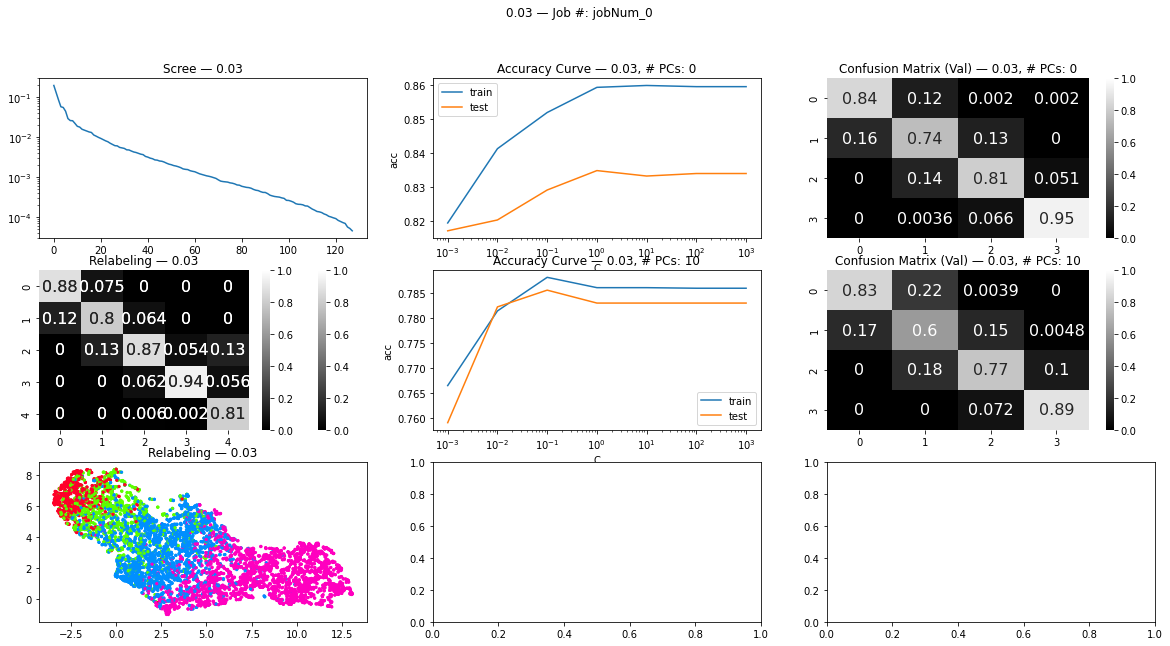

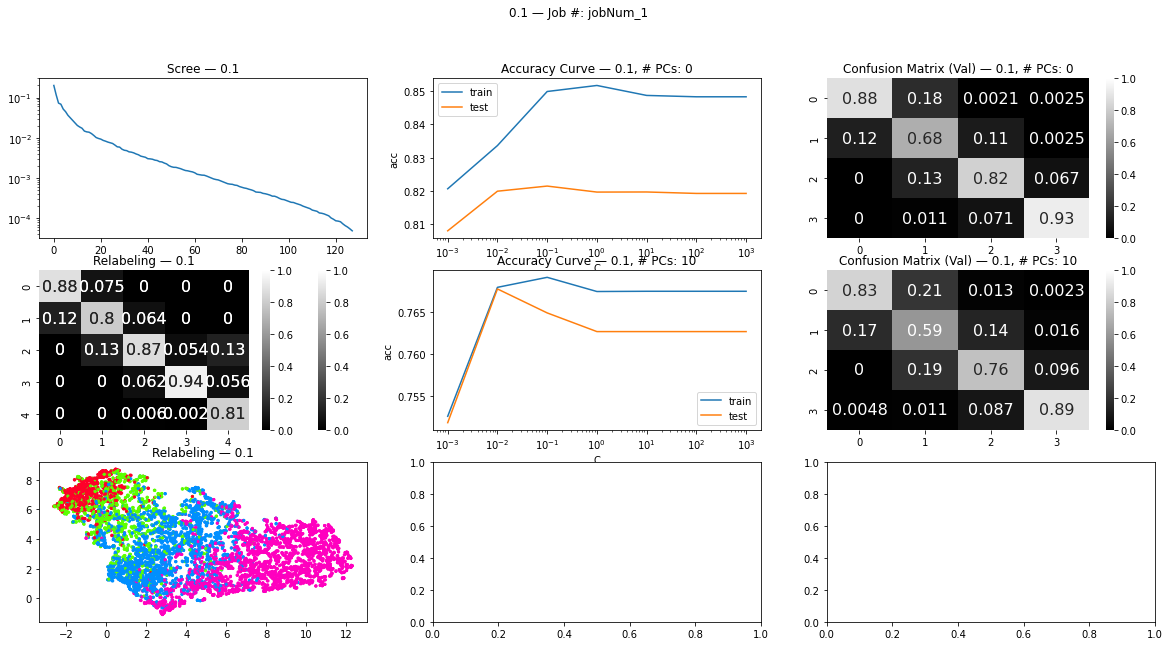

In [24]:
num_rows = max(len(pc_sweep), 3)

# jn = list(scree_plt_dct.keys())[1]
for jn in scree_plt_dct.keys():
    fig, ax = plt.subplots(num_rows, 3, figsize=(20,10))
    fig.suptitle(f"{run_id_dct[jn]} — Job #: {jn.split('/')[-1]}")
    
    scree_plt = scree_plt_dct[jn][0]
    ax[0,0].set_yscale('log')
    ax[0,0].set_title(f'Scree — {run_id_dct[jn]}')
    ax[0,0].plot(scree_plt)

    ax[1,0].set_title(f'Relabeling — {run_id_dct[jn]}')
    sns.heatmap(
        np.round(cm_plt_dct[jn][0]['cm_relabel'], 3),
        annot=True, 
        annot_kws={"size": 16}, 
        vmax=1., 
        cmap=plt.get_cmap('gray'),
        ax=ax[1,0]
    )



    ax[1,0].set_title(f'Relabeling — {run_id_dct[jn]}')
    sns.heatmap(
        np.round(cm_plt_dct[jn][0]['cm_relabel'], 3),
        annot=True, 
        annot_kws={"size": 16}, 
        vmax=1., 
        cmap=plt.get_cmap('gray'),
        ax=ax[1,0]
    )
    
    ax[2,0].scatter(embeddings_plt_dct[jn][0][:,0], embeddings_plt_dct[jn][0][:,1],
                s=5, c=labels_clean_plt_dct[jn][0], cmap='gist_rainbow')
    ax[2,0].set_title(f'Relabeling — {run_id_dct[jn]}')

#     ax[2,1].scatter(embeddings_plt_dct[jn][10][:,0], embeddings_plt_dct[jn][10][:,1],
#                 s=5, c=labels_clean_plt_dct[jn][10], cmap='gist_rainbow')
#     ax[2,1].set_title(f'Relabeling — {title_val_plt_dct[jn][10]}')

    for rank_num in trange(len(pc_sweep)):
        rank = pc_sweep[rank_num]
        print(rank)
        
        title_val = f'{run_id_dct[jn]}, # PCs: {rank}'

        ax[rank_num,1].plot(acc_plt_dct[jn][rank]['C'], acc_plt_dct[jn][rank]['acc_tr'])
        ax[rank_num,1].plot(acc_plt_dct[jn][rank]['C'], acc_plt_dct[jn][rank]['acc_val'])
        ax[rank_num,1].set_title(f'Accuracy Curve — {title_val}')
        ax[rank_num,1].set_xscale('log')
        ax[rank_num,1].set_xlabel('C')
        ax[rank_num,1].set_ylabel('acc')
        ax[rank_num,1].legend(['train', 'test']);
        
        ax[rank_num,2].set_title(f'Confusion Matrix (Val) — {title_val}')
        sns.heatmap(cm_plt_dct[jn][rank]['cm_val'], annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=ax[rank_num,2])

        
# for plt_inx in range(len(cm_tr_plt_lst)):
#     plt.figure()
#     sns.heatmap(cm_tr_plt_lst[plt_inx], annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
#     plt.title(f'train — {title_val_plt_lst[plt_inx]}');

In [25]:
# acc_plt_dct

In [26]:
# acc_plt_dct['/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp/jobNum_0']

In [27]:
# for jn in tqdm(scree_plt_dct):
#     plt.figure()
#     plt.plot(scree_plt_dct[jn])
#     plt.yscale('log')
#     plt.title(title_val_plt_lst[jn])

In [28]:
for plt_inx in range(len(corr_plt_lst)):
    plt.figure()
    plt.imshow(corr_plt_lst[plt_inx])
    plt.title(title_val_plt_lst[plt_inx])

NameError: name 'corr_plt_lst' is not defined

In [ ]:
for plt_inx in range(len(C_toUse_plt_lst)):
    plt.figure()
    plt.plot(C_toUse_plt_lst[plt_inx], acc_tr_plt_lst[plt_inx])
    plt.plot(C_toUse_plt_lst[plt_inx], acc_val_plt_lst[plt_inx])
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('acc')
    plt.legend(['train', 'test']);
    plt.title(title_val_plt_lst[plt_inx])

In [ ]:
for plt_inx in range(len(cm_tr_plt_lst)):
    plt.figure()
    sns.heatmap(cm_tr_plt_lst[plt_inx], annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
    plt.title(f'train — {title_val_plt_lst[plt_inx]}');

In [ ]:
for plt_inx in range(len(cm_val_plt_lst)):
    plt.figure()
    sns.heatmap(cm_val_plt_lst[plt_inx], annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
    plt.title(f'val — {title_val_plt_lst[plt_inx]}');

In [ ]:
for plt_inx in range(len(cm_relabel_plt_lst)):
    plt.figure()
    sns.heatmap(
        cm_relabel_plt_lst[plt_inx],
        annot=True, 
        annot_kws={"size": 16}, 
        vmax=1., 
        cmap=plt.get_cmap('gray')
    )
    plt.title(f'relabeling — {title_val_plt_lst[plt_inx]}')

In [ ]:
for plt_inx in range(len(img_grid_plt_lst)):
    plotting_helpers.plot_image_grid(img_grid_plt_lst[plt_inx], grid_shape=(15,15), kwargs_imshow={'vmax': 0.2});
    # plotting_helpers.plot_image_grid(torch.cat([arr for arr in layer_2], dim=0), grid_shape=(6,6), kwargs_imshow={'vmax': 0.2});
    # plotting_helpers.plot_image_grid(torch.cat([arr for arr in layer_3], dim=0), grid_shape=(4,6), kwargs_imshow={'vmax': 0.2});
    plt.title(title_val_plt_lst[plt_inx])

In [ ]:
for plt_inx in range(len(embeddings_plt_lst)):
    plt.figure()
    plt.scatter(embeddings_plt_lst[plt_inx][:,0], embeddings_plt_lst[plt_inx][:,1], s=5, c=labels_clean_plt_lst[plt_inx], cmap='gist_rainbow')
    plt.title(title_val_plt_lst[plt_inx])

In [ ]:
for plt_inx in range(len(scores_nn_plt_lst)):
    plt.figure()
    plt.scatter(scores_nn_plt_lst[plt_inx][:,1], scores_nn_plt_lst[plt_inx][:,0], c=labels_clean_plt_lst[plt_inx])
    plt.title(title_val_plt_lst[plt_inx])

In [ ]:
# Output report -- should include training loss curve
# Pull from loss.npy

In [ ]:
# params['params_changed']

In [ ]:
# mod_key_info = {}

# for imod, mod in enumerate(mod_dct_lst):
#     for key in mod:
#         if imod == 0:
#             mod_key_info[key] = mod[key]
#         else:
# #             mod_key_info[key].append(mod[key])
#             ac = np.allclose(mod_key_info[key], mod[key])
#             if not ac:
#                 print(key, ':', ac)